In [1]:
import sys
# 加载时老是从全局加载包 先改变路径，包尽量放在后面加载
for path in sys.path:
    print(path)

/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python39.zip
/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9
/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9/lib-dynload

/home1/yzhang/.local/lib/python3.9/site-packages
/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9/site-packages


In [2]:
# Define paths
env_site_packages = '/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9/site-packages'
user_site_packages = '/home1/yzhang/.local/lib/python3.9/site-packages'
# Remove env_site_packages if it already exists in sys.path to reinsert at correct position
if env_site_packages in sys.path:
    sys.path.remove(env_site_packages)
# Insert env_site_packages before user_site_packages
if user_site_packages in sys.path:
    user_index = sys.path.index(user_site_packages)
    sys.path.insert(user_index, env_site_packages)
else:
    sys.path.insert(0, env_site_packages)

# Verify the order of sys.path
for path in sys.path:
    print(path)
# Clear any loaded modules from the previous environment (if necessary)
#importlib.invalidate_caches()
# Reloading the specific module if necessary
#if 'matplotlib' in sys.modules:
#    del sys.modules['matplotlib']


/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python39.zip
/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9
/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9/lib-dynload

/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9/site-packages
/home1/yzhang/.local/lib/python3.9/site-packages


In [9]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os

In [10]:
import torch
import STAGATE_pyG

In [11]:
import sklearn.neighbors
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt

from torch_geometric.data import Data

In [12]:
from torch_geometric.data import InMemoryDataset
import torch_geometric.transforms as T

In [18]:
import datetime

# Data

In [4]:
# 含有每个细胞微环境的斑块信息
adata = sc.read_h5ad('/home1/yzhang/zy_data/Project_plaque/wx_data/full/Full_withplaque_ME_1204.h5ad')

In [5]:
adata.obs['label'].unique()
label_vec_uniq = list(set(adata.obs['label'])) 
label_vec_uniq

['13months-control-replicate_2',
 '13months-disease-replicate_1',
 '8months-control-replicate_2',
 '8months-disease-replicate_1',
 '13months-control-replicate_1',
 '8months-control-replicate_1',
 '8months-disease-replicate_2',
 '13months-disease-replicate_2']

In [6]:
# 挑选数据范围
adata = adata[
    #(adata.obs['label'] == '13months-disease-replicate_1') &
    (adata.obs['region'] == 'Cortex') #只要皮层
].copy()

In [7]:
#Normalization
sc.pp.highly_variable_genes(adata, n_top_genes=3000) #使用flavor="seurat_v3"需要安装micromamba install scanpy[skmisc] -c conda-forge 可选依赖项
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata) #原始count变成了normalize和log1p之后的

In [8]:
def Transfer_pytorch_Data(adata):
    G_df = adata.uns['Spatial_Net'].copy()
    cells = np.array(adata.obs_names)
    cells_id_tran = dict(zip(cells, range(cells.shape[0]))) #把cell id映射为0-细胞数
    G_df['Cell1'] = G_df['Cell1'].map(cells_id_tran)
    G_df['Cell2'] = G_df['Cell2'].map(cells_id_tran)

    G = sp.coo_matrix((np.ones(G_df.shape[0]), (G_df['Cell1'], G_df['Cell2'])), shape=(adata.n_obs, adata.n_obs))
    G = G + sp.eye(G.shape[0])

    edgeList = np.nonzero(G)
    if type(adata.X) == np.ndarray:
        data = Data(edge_index=torch.LongTensor(np.array(
            [edgeList[0], edgeList[1]])), x=torch.FloatTensor(adata.X),y=torch.FloatTensor(adata.obs["P_Pixel_Count"]))  # .todense()  P_Pixel_Count_r100
    else:
        data = Data(edge_index=torch.LongTensor(np.array(
            [edgeList[0], edgeList[1]])), x=torch.FloatTensor(adata.X.todense()),y=torch.FloatTensor(adata.obs["P_Pixel_Count"]))  # .todense()
    return data #返回带有edge和x的pyg data

------Calculating spatial graph...
The graph contains 30768 edges, 4323 cells.
7.1173 neighbors per cell on average.
Size of Input:  (4323, 2766)


/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9/site-packages/STAGATE_pyG/utils.py:194: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9/site-packages/STAGATE_pyG/utils.py:194: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/tmp/ipykernel_219127/2819564831.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [edgeList[0], edgeList[1]])), x=torch.FloatTensor(adata.X.todense()),y=torch.FloatTensor(adata.o

------Calculating spatial graph...
The graph contains 27370 edges, 3618 cells.
7.5650 neighbors per cell on average.
Size of Input:  (3618, 2766)


/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9/site-packages/STAGATE_pyG/utils.py:194: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9/site-packages/STAGATE_pyG/utils.py:194: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/tmp/ipykernel_219127/2819564831.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [edgeList[0], edgeList[1]])), x=torch.FloatTensor(adata.X.todense()),y=torch.FloatTensor(adata.o

------Calculating spatial graph...
The graph contains 38090 edges, 5039 cells.
7.5590 neighbors per cell on average.
Size of Input:  (5039, 2766)


/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9/site-packages/STAGATE_pyG/utils.py:194: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9/site-packages/STAGATE_pyG/utils.py:194: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/tmp/ipykernel_219127/2819564831.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [edgeList[0], edgeList[1]])), x=torch.FloatTensor(adata.X.todense()),y=torch.FloatTensor(adata.o

------Calculating spatial graph...
The graph contains 37006 edges, 4666 cells.
7.9310 neighbors per cell on average.
Size of Input:  (4666, 2766)


/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9/site-packages/STAGATE_pyG/utils.py:194: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9/site-packages/STAGATE_pyG/utils.py:194: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/tmp/ipykernel_219127/2819564831.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [edgeList[0], edgeList[1]])), x=torch.FloatTensor(adata.X.todense()),y=torch.FloatTensor(adata.o

------Calculating spatial graph...
The graph contains 26882 edges, 3540 cells.
7.5938 neighbors per cell on average.
Size of Input:  (3540, 2766)


/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9/site-packages/STAGATE_pyG/utils.py:194: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9/site-packages/STAGATE_pyG/utils.py:194: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/tmp/ipykernel_219127/2819564831.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [edgeList[0], edgeList[1]])), x=torch.FloatTensor(adata.X.todense()),y=torch.FloatTensor(adata.o

------Calculating spatial graph...
The graph contains 27422 edges, 3842 cells.
7.1374 neighbors per cell on average.
Size of Input:  (3842, 2766)


/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9/site-packages/STAGATE_pyG/utils.py:194: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9/site-packages/STAGATE_pyG/utils.py:194: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/tmp/ipykernel_219127/2819564831.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [edgeList[0], edgeList[1]])), x=torch.FloatTensor(adata.X.todense()),y=torch.FloatTensor(adata.o

------Calculating spatial graph...
The graph contains 31298 edges, 4399 cells.
7.1148 neighbors per cell on average.
Size of Input:  (4399, 2766)


/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9/site-packages/STAGATE_pyG/utils.py:194: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9/site-packages/STAGATE_pyG/utils.py:194: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/tmp/ipykernel_219127/2819564831.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [edgeList[0], edgeList[1]])), x=torch.FloatTensor(adata.X.todense()),y=torch.FloatTensor(adata.o

------Calculating spatial graph...
The graph contains 24880 edges, 3579 cells.
6.9517 neighbors per cell on average.
Size of Input:  (3579, 2766)


/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9/site-packages/STAGATE_pyG/utils.py:194: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/public/home/yzhang/micromamba/envs/STAGATE_pyG/lib/python3.9/site-packages/STAGATE_pyG/utils.py:194: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/tmp/ipykernel_219127/2819564831.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [edgeList[0], edgeList[1]])), x=torch.FloatTensor(adata.X.todense()),y=torch.FloatTensor(adata.o

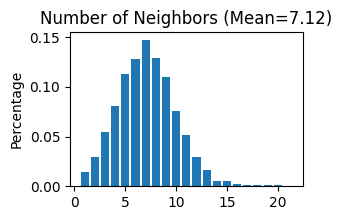

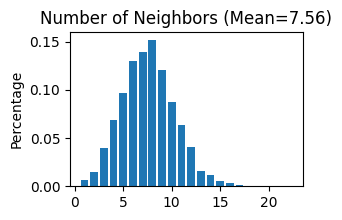

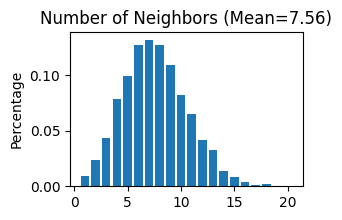

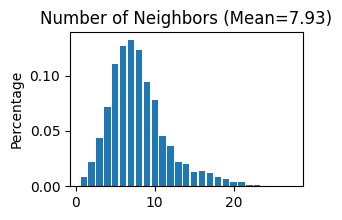

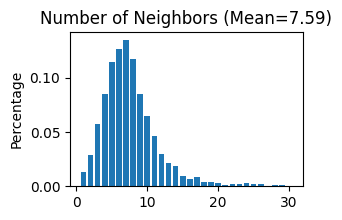

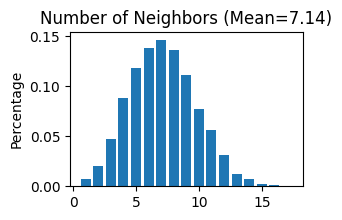

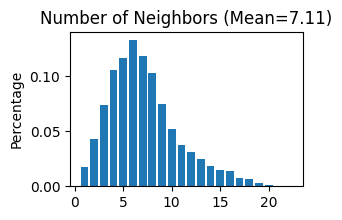

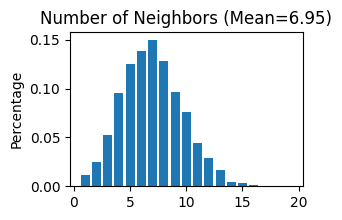

In [14]:
data_list=[]
for graph_index in range(0, len(label_vec_uniq)):
    st_data = adata[(adata.obs['label'] == label_vec_uniq[graph_index])].copy()
    STAGATE_pyG.Cal_Spatial_Net(st_data, rad_cutoff=100)
    STAGATE_pyG.Stats_Spatial_Net(st_data)
    st_data.X = sp.csr_matrix(st_data.X) #变为稀疏矩阵
    if 'highly_variable' in st_data.var.columns:
        st_data_Vars =  st_data[:, st_data.var['highly_variable']]
    else:
        st_data_Vars = st_data
    print('Size of Input: ', st_data_Vars.shape)
    if 'Spatial_Net' not in st_data.uns.keys():
        raise ValueError("Spatial_Net is not existed! Run Cal_Spatial_Net first!")
    data = Transfer_pytorch_Data(st_data_Vars) #pyg data对象
    data_list.append(data)

In [15]:
data_list

[Data(x=[4323, 2766], edge_index=[2, 35091], y=[4323]),
 Data(x=[3618, 2766], edge_index=[2, 30988], y=[3618]),
 Data(x=[5039, 2766], edge_index=[2, 43129], y=[5039]),
 Data(x=[4666, 2766], edge_index=[2, 41672], y=[4666]),
 Data(x=[3540, 2766], edge_index=[2, 30422], y=[3540]),
 Data(x=[3842, 2766], edge_index=[2, 31264], y=[3842]),
 Data(x=[4399, 2766], edge_index=[2, 35697], y=[4399]),
 Data(x=[3579, 2766], edge_index=[2, 28459], y=[3579])]

# 保存为Dataset

In [16]:
ThisStep_OutputFolderName = "/home1/yzhang/zy_data/Project_plaque/GCN/STAGATE/Data"
if os.path.exists(ThisStep_OutputFolderName):
    shutil.rmtree(ThisStep_OutputFolderName)
os.makedirs(ThisStep_OutputFolderName)

In [19]:
# Define "SpatialOmicsImageDataset" class based on ordinary Python list.
class SpatialOmicsWangxiao(InMemoryDataset):                                         
    def __init__(self, root, transform=None, pre_transform=None):
        super(SpatialOmicsWangxiao, self).__init__(root, transform, pre_transform)  
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['SpatialOmicsWangxiao.pt']                                           

    def download(self):
        pass
    
    def process(self):
        # Read data_list into huge `Data` list.
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

# Create an object of this "SpatialOmicsImageDataset" class.
dataset = SpatialOmicsWangxiao(ThisStep_OutputFolderName) #transform=T.ToDense(max_nodes)
print("Step1 done!")
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

/tmp/ipykernel_219127/3568559847.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])


Step1 done!
2025-01-07 05:01:21


# 读入Dataset

In [20]:
dataset

SpatialOmicsWangxiao(8)

In [21]:
from torch_geometric.loader import DataLoader

## batch_size=8相当于把8个子图整合在一起

In [36]:
dataloader = DataLoader(dataset,batch_size=2)
print(dataloader.dataset.data)
for data in dataloader:
    print(data)
data.batch

Data(x=[33006, 2766], edge_index=[2, 276722], y=[33006])
DataBatch(x=[7941, 2766], edge_index=[2, 66079], y=[7941], batch=[7941], ptr=[3])
DataBatch(x=[9705, 2766], edge_index=[2, 84801], y=[9705], batch=[9705], ptr=[3])
DataBatch(x=[7382, 2766], edge_index=[2, 61686], y=[7382], batch=[7382], ptr=[3])
DataBatch(x=[7978, 2766], edge_index=[2, 64156], y=[7978], batch=[7978], ptr=[3])


tensor([0, 0, 0,  ..., 1, 1, 1])

DataBatch(x=[7941, 2766], edge_index=[2, 66079], y=[7941], batch=[7941], ptr=[3])
DataBatch(x=[9705, 2766], edge_index=[2, 84801], y=[9705], batch=[9705], ptr=[3])
DataBatch(x=[7382, 2766], edge_index=[2, 61686], y=[7382], batch=[7382], ptr=[3])
DataBatch(x=[7978, 2766], edge_index=[2, 64156], y=[7978], batch=[7978], ptr=[3])


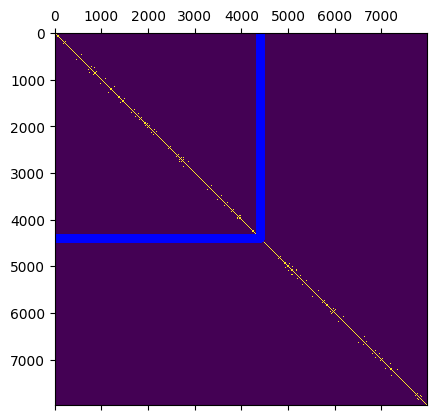

In [25]:
dataloader = DataLoader(dataset,batch_size=2)
for data in dataloader:
    print(data)
    
    
import matplotlib.pyplot as plt
from torch_geometric.utils import to_dense_adj


adj = to_dense_adj(data.edge_index)[0]
plt.matshow(adj)
tmp = int(data.batch.unique(return_counts=True)[1][0])
plt.scatter(np.ones(tmp)*tmp,np.arange(0,tmp),s=20,color="blue")
plt.scatter(np.arange(0,tmp),np.ones(tmp)*tmp,s=20,color="blue")
plt.show()

# 训练的时候

In [ ]:
model = STAGATE(hidden_dims = [dataset.x.shape[1]] + hidden_dims).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
from torch_geometric.loader import DataLoader
train_loader=DataLoader(dataset,batch_size=8)

In [ ]:
from tqdm import tqdm
loss_list = []
for epoch in tqdm(range(1, n_epochs+1)):
    model.train()

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        z, out = model(data.x, data.edge_index)
        loss = F.mse_loss(data.x, out) #重构
        #loss = F.mse_loss(out.squeeze()[data.train_mask], data.y[data.train_mask].float()) #data.x, out F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss_list.append(loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
        optimizer.step()